# Numerical results

### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


from scipy.io import loadmat

import time

# 2D Dam break problem

### Functions
The MUSCL-Hancock scheme for the 2D SWE with the Rusanov numerical flux.

In [2]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


### Idealised 2D dam break

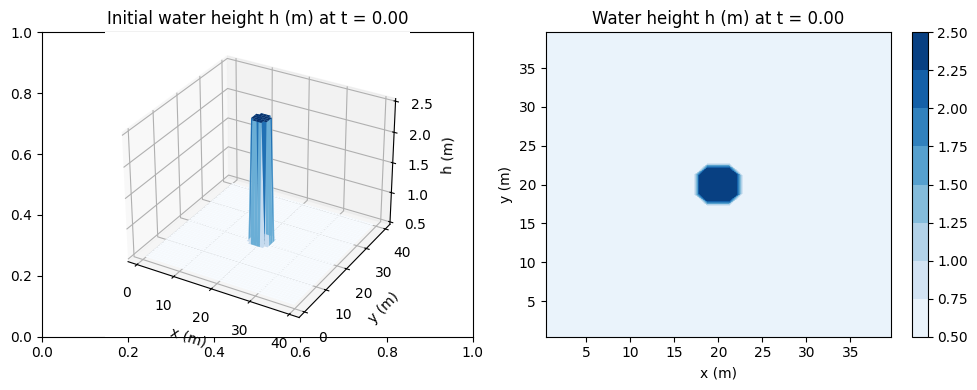

In [54]:
# Global constants
g = 9.81  # gravity
Nx = 50
Ny = 50
xL, xR = 0, 40
yL, yR = 0, 40
t = 0
tend =  7# 1 
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Center
xc = 20
yc = 20

# Radius
R = 2.5

# Initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)
for i in range(Nx):
    for j in range(Ny):
        r = np.sqrt((x[i] - xc)**2 + (y[j] - yc)**2)
        if r < R:
            Q[0, i, j] = 2.5
        else:
            Q[0, i, j] = 0.5


# Plot the initial data in 3d and in contour
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cmap = 'Blues'

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
ax1.set_title(f'Initial water height h (m) at t = {t:.2f}')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('h (m)')

# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water height h (m) at t = {t:.2f}')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')

# Show the combined plot
plt.tight_layout()
plt.show()

In [28]:
if 0:    
    X, Y = np.meshgrid(x, y)

    # Plot the initial data in 3d
    fig = plt.figure(figsize=(12, 10))

    # 3D Surface plot on the first subplot
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
    ax1.set_title('Initial water height h (m)', fontsize=36)
    ax1.set_xlabel('x (m)', fontsize=16)
    ax1.set_ylabel('y (m)', fontsize=16)
    ax1.set_zlabel('h (m)', fontsize=16)

    # Save figure
    if 0:
        plt.savefig('plots/initial_water_height_3D.pdf', format='pdf')

    plt.show()


In [29]:
Q_all = []
Q_all.append(Q)

# Start timer
start_time = time.time()

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, (i+1) % Nx, j], fxp[:, i, j], fxm[:, (i+1) % Nx, j], sxp[:, i, j], sxm[:, (i+1) % Nx, j])
            elif i == Nx - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, (i-1) % Nx, j], Qxm[:, i, j], fxp[:, (i-1) % Nx, j], fxm[:, i, j], sxp[:, (i-1) % Nx, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, (i-1) % Nx, j], Qxm[:, i, j], fxp[:, (i-1) % Nx, j], fxm[:, i, j], sxp[:, (i-1) % Nx, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, (i+1) % Nx, j], fxp[:, i, j], fxm[:, (i+1) % Nx, j], sxp[:, i, j], sxm[:, (i+1) % Nx, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, (j+1) % Ny], gyp[:, i, j], gym[:, i, (j+1) % Ny], syp[:, i, j], sym[:, i, (j+1) % Ny])
            elif j == Ny - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, (j-1) % Ny], Qym[:, i, j], gyp[:, i, (j-1) % Ny], gym[:, i, j], syp[:, i, (j-1) % Ny], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, (j-1) % Ny], Qym[:, i, j], gyp[:, i, (j-1) % Ny], gym[:, i, j], syp[:, i, (j-1) % Ny], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, (j+1) % Ny], gyp[:, i, j], gym[:, i, (j+1) % Ny], syp[:, i, j], sym[:, i, (j+1) % Ny])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)
            

    # Update time and solution
    t += dt
    # Print t with 3 decimals
    print(f't = {t:.3f}')
    Q = np.copy(Qnew)
    Q_all.append(Q)

n = len(Q_all)
print(f'There are time steps: {n}')

# End timer
end_time = time.time()

# Print the time taken
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.2f} seconds')


t = 0.073
t = 0.143
t = 0.210
t = 0.274
t = 0.338
t = 0.401
t = 0.464
t = 0.528
t = 0.592
t = 0.657
t = 0.724
t = 0.792
t = 0.861
t = 0.932
t = 1.005
t = 1.079
t = 1.155
t = 1.232
t = 1.310
t = 1.390
t = 1.471
t = 1.553
t = 1.637
t = 1.722
t = 1.808
t = 1.895
t = 1.983
t = 2.072
t = 2.162
t = 2.254
t = 2.346
t = 2.439
t = 2.534
t = 2.629
t = 2.725
t = 2.822
t = 2.920
t = 3.019
t = 3.118
t = 3.219
t = 3.320
t = 3.422
t = 3.525
t = 3.628
t = 3.732
t = 3.837
t = 3.943
t = 4.049
t = 4.156
t = 4.264
t = 4.372
t = 4.481
t = 4.590
t = 4.700
t = 4.811
t = 4.922
t = 5.033
t = 5.146
t = 5.258
t = 5.372
t = 5.485
t = 5.600
t = 5.715
t = 5.830
t = 5.946
t = 6.062
t = 6.180
t = 6.298
t = 6.417
t = 6.536
t = 6.656
t = 6.777
t = 6.898
t = 7.000
There are time steps: 75
Time taken: 15.64 seconds


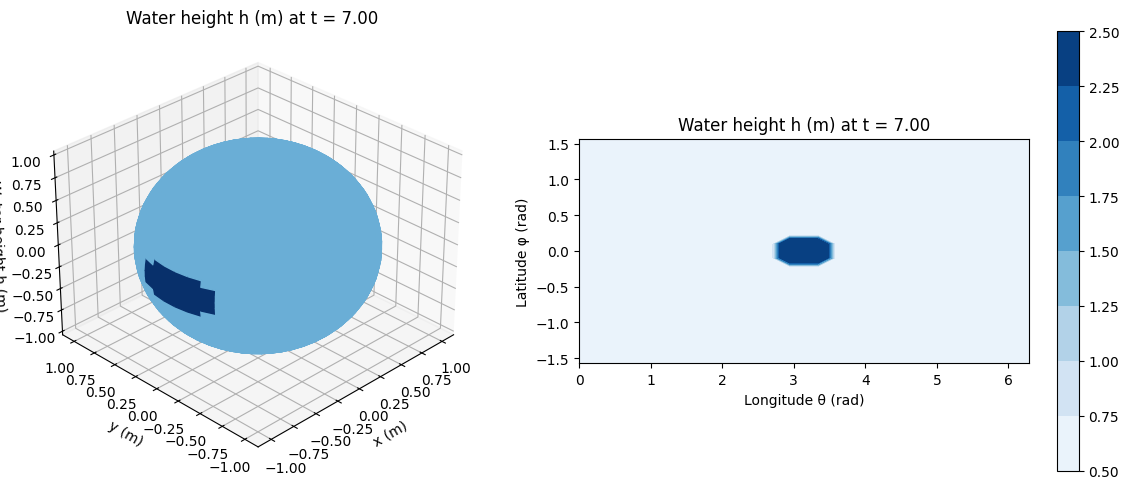

In [52]:
## Wrap on a sphere
idx = 0

# Define grid in lat/lon space (latitude φ, longitude θ)
phi = np.linspace(-np.pi/2, np.pi/2, Q.shape[1])  # Latitude range from -90° to 90°
theta = np.linspace(0, 2*np.pi, Q.shape[2])  # Longitude range from 0° to 360°
cmap = 'Blues'

# Convert to meshgrid for spherical coordinates
phi, theta = np.meshgrid(phi, theta)

# Convert to Cartesian coordinates for plotting on the sphere
r = 1  # Radius of the sphere (can be adjusted)
X_sphere = r * np.cos(phi) * np.cos(theta)  # X coordinate
Y_sphere = r * np.cos(phi) * np.sin(theta)  # Y coordinate
Z_sphere = r * np.sin(phi)  # Z coordinate

# Plot the final data in 3D and in contour
fig = plt.figure(figsize=(12, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_sphere, Y_sphere, Z_sphere, facecolors=plt.cm.Blues(Q_all[idx][0, :, :]), rstride=1, cstride=1, antialiased=True, shade=False)
ax1.set_title(f'Water height h (m) at t = {t:.2f}')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.view_init(30, 45+180)
ax1.set_zlabel('Water height h (m)')

# Contour plot on the second subplot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(theta, phi, Q_all[idx][0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water height h (m) at t = {t:.2f}')
ax2.set_xlabel('Longitude θ (rad)')
ax2.set_ylabel('Latitude φ (rad)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()